In [1]:
import os
from tqdm import tqdm
from joblib import Parallel, delayed
import xarray as xa
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.colors as mpcrs
from matplotlib import ticker
from scipy.interpolate import CubicSpline
from pylibs.utils import get_dates
from pylibs.plot_utils import set_size
from pylibs.custom_colormaps import white_gist_earth
from pylibs.plot_utils import set_size, setupax_2dmap

In [2]:
verbose = False
plotting = True
fsave = True
quality = 600
proj = ccrs.PlateCarree()

In [3]:
sdate = 2024110100
edate = 2024113018
date_interval = 6
window_length = 6
dates = get_dates(sdate, edate, date_interval)
bkg = 'MERRA-2'

In [4]:
hofx_path = '/glade/work/swei/Git/JEDI-METplus/output/aodobs_merra2/hofx/f00'
obs_name_list = [
    'modis_terra_aod', 'modis_aqua_aod',
    'pace_aod',
    'viirs_aod_dt_npp', 'viirs_aod_dt_n20',
    'viirs_aod_db_npp', 'viirs_aod_db_n20',
]

aeronet_aod_wvl = [340., 380., 440., 500., 675, 870., 1020., 1640.]
select_aeronet_wvl = [440., 500., 675.]
target_wvl = 550.

# Control hist2d
hist2d_in_log=1
hist2d_xmax=5.0
hist2d_xybins=30

if hist2d_in_log:
    h2d_axis = np.linspace(np.log(0.01), np.log(hist2d_xmax), hist2d_xybins+1)
    h2d_axis = np.exp(h2d_axis)
else:
    h2d_axis = np.linspace(0.01, hist2d_xmax, hist2d_xybins+1)

In [5]:
savedir = '/glade/work/swei/projects/mmm.pace_aod/plots'
stat_savedir = f'{savedir}/stats/vs_AERONET_L1.5'
if not os.path.exists(stat_savedir):
    os.makedirs(stat_savedir)

In [6]:
# Functions setup
def cubicSplineInterpolate(row):
    x = select_aeronet_wvl
    y = row[['440nm', '500nm', '675nm']].values
    spline = CubicSpline(x, y)
    return float(spline(target_wvl))
    
def haversineDistance(row, reflat, reflon):
    earthR = 6371.
    lat1 = np.radians(row['latitude'])
    lon1 = np.radians(row['longitude'])
    lat2 = np.radians(reflat)
    lon2 = np.radians(reflon)

    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = np.sin(dlat / 2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return earthR * c

def plt_hist2d(dataframe, x, y, axis, save, savename, **kwargs):
    # x is for truth, y is for verification.
    x_data = dataframe[x]
    y_data = dataframe[y]
    xlbstr = kwargs.get('xlb', x)
    ylbstr = kwargs.get('ylb', y)
    hist2d, x_edge, y_edge = np.histogram2d(x_data,
                                            y_data,
                                            bins=axis)

    cnlvs = np.linspace(0, hist2d.max(), 256)
    clrnorm = mpcrs.BoundaryNorm(cnlvs, len(cnlvs), extend='max')

    fig, ax = plt.subplots()
    set_size(5, 5, b=0.1, l=0.1, r=0.95, t=0.95)
    cn = ax.contourf(axis[:-1], axis[:-1], hist2d.swapaxes(0,1),
                     levels=cnlvs, norm=clrnorm, cmap=white_gist_earth,
                     extend='max')
    plt.plot(
        [0.0, hist2d_xmax],
        [0.0, hist2d_xmax],
        color='gray',
        linewidth=2,
        linestyle='--'
    )
    plt.xlim(0.01, hist2d_xmax)
    plt.ylim(0.01, hist2d_xmax)

    if hist2d_in_log:
        ax.set_xscale('log')
        ax.set_yscale('log')
    ax.set_aspect('equal')

    plt.grid(alpha=0.5)
    plt.xlabel(xlbstr, fontsize=11)
    plt.ylabel(ylbstr, fontsize=11)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

    correlation_matrix = np.corrcoef(x_data, y_data)
    correlation_xy = correlation_matrix[0, 1]
    r_squared = correlation_xy ** 2
    bias = np.mean(y_data) - np.mean(x_data)
    rbias = bias/np.mean(x_data)
    ssize = len(x_data)
    rmse = np.sqrt(np.mean((y_data - x_data) ** 2))

    stats_dict = {
        'Counts': str("%.0f" % ssize),
        'Absolute Bias': str("%.3f" % bias),
        'Relative Bias': str("%.3f" % rbias),
        'RMSE': str("%.3f" % rmse),
        # 'R': str("%.3f" % correlation_xy),
        'R\u00b2': str("%.3f" % r_squared),
    }
    x_pos = 0.012
    y_pos = 1.02
    for key in stats_dict.keys():
        stat_str = '%s= %s' %(key, stats_dict[key])
        y_pos = y_pos - 0.05
        ax.annotate(stat_str, (x_pos, y_pos), ha='left', va='center', 
                    fontsize=12, xycoords='axes fraction')

    cb = plt.colorbar(cn, orientation='horizontal', fraction=0.03, aspect=30, 
                      pad=0.12, extend='max', ticks=cnlvs[::50])
    cb.ax.minorticks_off()
    cb.ax.ticklabel_format(axis='x', style='sci', scilimits=(0, 0),
                           useMathText=True)

    if save:
        plt.savefig(savename, dpi=quality)
    plt.close(fig)
    return

In [7]:
def readAeronetIoda(iodafile):
    metads = xa.open_dataset(iodafile, group='MetaData')
    obsvds = xa.open_dataset(iodafile, group='ObsValue').assign_coords(Channel=aeronet_aod_wvl)
    df = pd.DataFrame()
    for wvl in select_aeronet_wvl:
        col_name = f'{int(wvl)}nm'
        df[col_name] = obsvds['aerosolOpticalDepth'].sel(Channel=wvl)
    df['station'] = metads['stationIdentification']
    df['dateTime'] = metads['dateTime']
    df['latitude'] = metads['latitude']
    df['longitude'] = metads['longitude']
    df = df.dropna()
    df['AOD550nm'] = df.apply(cubicSplineInterpolate, axis=1)
    return df

In [8]:
def readAodProdIoda(iodafile):
    metads = xa.open_dataset(iodafile, group='MetaData')
    if 'pace_aod' in iodafile:
        tmpwvl = metads['sensorCentralWavelength'].values * 1e3
    else:
        tmpwvl = [550.]
    obsvds = xa.open_dataset(iodafile, group='ObsValue').assign_coords(Channel=tmpwvl)
    hofxds = xa.open_dataset(iodafile, group='hofx').assign_coords(Channel=tmpwvl)
    df = pd.DataFrame()
    df['dateTime'] = metads['dateTime']
    df['latitude'] = metads['latitude']
    df['longitude'] = metads['longitude']
    df['AOD550nm'] = obsvds['aerosolOpticalDepth'].sel(Channel=target_wvl)
    df['hofx550'] = hofxds['aerosolOpticalDepth'].sel(Channel=target_wvl)
    return df

In [9]:
def process_dates(cdate, obsname):
    # hrave_aeronet_df = pd.DataFrame()
    collocated_aodprod_df = pd.DataFrame()
    # for cdate in tqdm(dates):
    cdate_str = datetime.strftime(cdate, "%Y%m%d%H")
    win_beg = cdate - timedelta(hours=0.5*window_length)
    win_end = cdate + timedelta(hours=0.5*window_length)
    subdates = pd.date_range(start=win_beg, end=win_end, freq=timedelta(hours=1))
    aeronet_file = f'{hofx_path}/aeronet_l15_aod/hofx.aeronet_l15_aod.{cdate_str}.nc4'
    aeronet_obsdf = readAeronetIoda(aeronet_file)

    aodprod_file = f'{hofx_path}/{obsname}/hofx.{obsname}.{cdate_str}.nc4'
    aodprod_obsdf = readAodProdIoda(aodprod_file)

    for d in range(window_length):
        hr_beg = subdates[d]
        hr_end = subdates[d+1]
        mid_hr = hr_beg + 0.5 * (hr_end - hr_beg)
        delta_hr = round((mid_hr - cdate).total_seconds()/3600., 1)
        hr_filter = (aeronet_obsdf['dateTime'] >= hr_beg) & (aeronet_obsdf['dateTime'] <= hr_end)
        hr_obsdf = aeronet_obsdf.loc[(hr_filter)]
        hrave_df = hr_obsdf.groupby(hr_obsdf['station']).mean().reset_index()
        hrave_df['dateTime'] = mid_hr
        hrave_df['deltaHour'] = delta_hr

        hr_prod_df = aodprod_obsdf[
            (aodprod_obsdf['dateTime'] >= hr_beg) & 
            (aodprod_obsdf['dateTime'] <= hr_end)
        ].reset_index(drop=True)
    
        # Create collocated dataframe
        for ref in hrave_df.itertuples(index=True):
            if verbose: print(f'{ref.dateTime} at {ref.station}')
            ref_lat = ref.latitude
            ref_lon = ref.longitude
            gross_filter = (
                (hr_prod_df['latitude'] < (ref_lat+1)) &
                (hr_prod_df['latitude'] > (ref_lat-1)) &
                (hr_prod_df['longitude'] < (ref_lon+1)) &
                (hr_prod_df['longitude'] > (ref_lon-1))
            )
            if any(gross_filter):
                tmpdf = hr_prod_df.loc[gross_filter].reset_index(drop=True)
                tmpdf['distance'] = tmpdf.apply(haversineDistance, axis=1, args=(ref_lat, ref_lon))
                tmpdf = tmpdf.loc[tmpdf['distance']<100].reset_index(drop=True)
                tmpdf['station'] = ref.station
                tmpdf['station lat'] = ref.latitude
                tmpdf['station lon'] = ref.longitude
                tmpdf['deltaHour'] = ref.deltaHour
                tmpdf['AERONET AOD 550nm'] = ref.AOD550nm
                tmpdf['obsname'] = obsname
                collocated_aodprod_df = pd.concat((collocated_aodprod_df, tmpdf), axis=0)
            else:
                if verbose: print('No Data within +/- 1 degree of AERONET station')
                continue
    return collocated_aodprod_df

In [10]:
all_df = pd.DataFrame()
for obs in obs_name_list:
    print(f'Processing {obs}')
    results = Parallel(n_jobs=-1)(delayed(process_dates)(cdate, obs) for cdate in tqdm(dates))
    tmpdf = pd.concat(results, ignore_index=True)
    if plotting:
        hist2dplt = f'{stat_savedir}/obs_vs_AERONET.hist2d.{obs}.{sdate}_{edate}.png'
        plt_hist2d(tmpdf, 'AERONET AOD 550nm', 'AOD550nm', h2d_axis, fsave, hist2dplt,
                   xlb='AERONET AOD 550nm',
                   ylb=f'{obs} AOD 550nm')
        hist2dplt = f'{stat_savedir}/hfx_vs_AERONET.hist2d.{obs}.{sdate}_{edate}.png'
        plt_hist2d(tmpdf, 'AERONET AOD 550nm', 'hofx550', h2d_axis, fsave, hist2dplt,
                   xlb='AERONET AOD 550nm',
                   ylb=f'{obs} HofX 550nm based on {bkg}')
        for deltahr in [-2.5, -1.5, -0.5, 0.5, 1.5, 2.5]:
            sub_hr_df = tmpdf.loc[tmpdf['deltaHour'] == deltahr].reset_index(drop=True)
            hist2dplt = f'{stat_savedir}/hfx{deltahr}_vs_AERONET.hist2d.{obs}.{sdate}_{edate}.png'
            plt_hist2d(sub_hr_df, 'AERONET AOD 550nm', 'hofx550', h2d_axis, fsave, hist2dplt,
                       xlb='AERONET AOD 550nm',
                       ylb=f'{obs} {deltahr}H HofX 550nm based on {bkg}')
    all_df = pd.concat((all_df, tmpdf), axis=0)
print('Process Finished')

Processing modis_terra_aod


100%|██████████| 120/120 [00:04<00:00, 24.76it/s]


Processing modis_aqua_aod


100%|██████████| 120/120 [00:01<00:00, 61.62it/s]


Processing pace_aod


100%|██████████| 120/120 [00:02<00:00, 42.71it/s]


Processing viirs_aod_dt_npp


100%|██████████| 120/120 [00:04<00:00, 29.85it/s]


Processing viirs_aod_dt_n20


100%|██████████| 120/120 [00:04<00:00, 28.43it/s]


Processing viirs_aod_db_npp


100%|██████████| 120/120 [00:03<00:00, 31.22it/s]


Processing viirs_aod_db_n20


100%|██████████| 120/120 [00:03<00:00, 30.71it/s]


Process Finished


In [11]:
np.unique(all_df['station'])

array(['AAQ10_MY_Banting', 'AAU_Jackros_ET', 'ALERIA_MF', 'AOE_Baotou',
       'ARM_BNF', 'ARM_CRG', 'ARM_Graciosa', 'ARM_KCG', 'ARM_SGP',
       'ASI_Malindi', 'ATHENS_NTUA', 'ATTO-Campina', 'AU_NSW_Lidcombe',
       'AU_NSW_Merriwa', 'Agen_Palissy', 'AgiaMarina_Xyliatou',
       'Alta_Floresta_IF', 'Amazon_ATTO_Tower', 'American_Samoa', 'Ames',
       'Amity_Univ_Gurgaon', 'Amsterdam_Island', 'Anmyon',
       'Antikythera_NOA', 'Aosta', 'Appalachian_State',
       'Apulian_Tavoliere', 'Aras_de_los_Olmos', 'Arcachon', 'Arcata_CA',
       'Arica', 'Aspendale_Mel_AU', 'Aubiere_LAMP', 'BMKG_Jakarta',
       'BONDVILLE', 'Bac_Lieu', 'Badajoz', 'Bakersfield', 'Bambey-ISRA',
       'Bandung', 'Bangkok', 'Banizoumbou', 'Barcelona', 'Bayfordbury',
       'Beijing_PKU', 'Bhola', 'Billerica', 'Birdsville', 'Birkenes',
       'Bozeman', 'Bratts_Lake', 'Brest_MF', 'Brno_Airport', 'Brookhaven',
       'Brussels', 'Bukit_Kototabang', 'Burjassot', 'CARTEL',
       'CASP_Watkins_CO_USA', 'CATUC_Bamen

In [13]:
counts = all_df['station'].value_counts().reset_index()
counts.columns = ['station', 'count']
latlon = all_df.drop_duplicates(subset='station')[['station', 'station lat', 'station lon']]
station_count_df = pd.merge(counts, latlon, on='station')

In [17]:
station_count_df

,station,count,station lat,station lon,size
0,IITM_ARTCI_Bhopal,113305,23.572260,77.244293,600.000000
1,Jaipur,103450,26.905817,75.806213,547.813424
2,NUST_Islamabad,80854,33.647865,72.989304,428.157628
3,Ilorin,76635,8.484100,4.674500,405.816160
4,Amity_Univ_Gurgaon,73866,28.317329,76.916031,391.153082
...,...,...,...,...,...
418,Camaguey,57,21.422300,-77.849899,0.301840
419,Churchill,48,58.736000,-93.818169,0.254181
420,Vechernaya_Hill,18,-67.660004,46.158001,0.095318
421,Chajnantor,13,-22.959314,-67.786118,0.068841


In [32]:
station_count_df['size'] = station_count_df['count'] / max(station_count_df['count'].values) * quality
cnt2size_ratio = max(station_count_df['count'].values) / quality
legend_sizes = [50, 200, 400]  # sizes you want to show in legend
legend_cnts = [round(size * cnt2size_ratio) for size in legend_sizes]

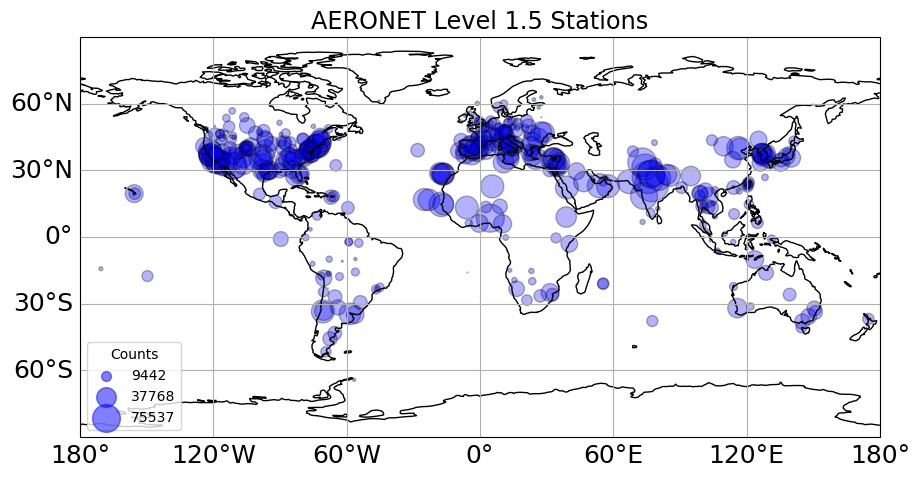

In [39]:
area_corner = [-90., 90., -180., 180.]

fig, ax, gl = setupax_2dmap(area_corner, 'Glb', proj, lbsize=18)
set_size(8, 5)

# Scatter
sc = ax.scatter(
    station_count_df['station lon'], station_count_df['station lat'],
    s=station_count_df['size'],  # scale size
    color='blue', alpha=0.3, edgecolor='black', transform=ccrs.PlateCarree()
)

handles = [plt.scatter([], [], s=size, color='blue', alpha=0.5, label=f'{cnts}')
           for size, cnts in zip(legend_sizes, legend_cnts)]
plt.legend(handles=handles, title='Counts', loc=3)
plt.title('AERONET Level 1.5 Stations', size='xx-large')
stationplt = f'{stat_savedir}/AERONETL15.{sdate}_{edate}.png'
fig.savefig(stationplt, dpi=quality)

In [40]:
stationplt

'/glade/work/swei/projects/mmm.pace_aod/plots/stats/vs_AERONET_L1.5/AERONETL15.2024110100_2024113018.png'